# Correlation Strategy (Mean reversion basic implementation)

1. [Theory](#theory)
2. [Login](#login)
3. [Data Downloading](#data-downloading)
4. [Correlation Analysis](#correlation-analysis)
5. [Strategy Implementation](#strategy-implementation)
6. [Results Explanation](#results-explanation)
7. [Possible Errors](#possible-errors)


### Theory

Mean Reversion strategies assume that prices or relationships between assets tend to return to a typical value over time. Instead of relying on complex mathematical models like the Ornstein-Uhlenbeck process

$$
dX_t = \theta (\mu - X_t) \, dt + \sigma \, dW_t
$$

Or strict stationarity tests, a more practical approach is to **identify pairs of assets with strong historical correlation**.

When two assets move closely together, any significant divergence may present a trading opportunity—buy the underperformer and sell the outperformer, expecting them to revert to their usual relationship. 

Although statistical models and stationarity tests (like ADF or KPSS) can be useful, **successful strategies can often be developed by focusing on correlation patterns**, which are easier to compute and interpret.We can observe two type of strategies.

## 📘 Mean Equation

The *mean equation* represents the conditional expected value of a dependent variable given one or more regressors:

$$
\mathbb{E}[Y \mid X] = \alpha + \beta X
$$

---

## 📗 Population Model

The *population model* explicitly includes the random error term:

$$
Y = \alpha + \beta X + \varepsilon
$$

Where:
- \( Y \): dependent variable (target)
- \( X \): independent variable (predictor)
- \( \alpha \): intercept
- \( \beta \): regression coefficient
- \( \varepsilon \): random error term




In [1]:
# ===========================================
# 📦 Import required libraries
# ===========================================
import pandas as pd  # For data manipulation and analysis (install: pip install pandas)
import numpy as np  # For numerical operations (install: pip install numpy)
import MetaTrader5 as mt5  # MT5 API to interact with the MetaTrader 5 terminal (install: pip install MetaTrader5)
from datetime import datetime  # To work with date/time ranges
import os  # For accessing environment variables
from dotenv import load_dotenv  # To load sensitive data (login, password) from .env file (install: pip install python-dotenv)
import yfinance as yf  # Yahoo Finance API wrapper (install: pip install yfinance)
from yahooquery import search  # For searching assets (install: pip install yahooquery)
import matplotlib.pyplot as plt  # For visualization (install: pip install matplotlib)
import json #For data manipulation
import statsmodels.formula.api as smf
from pandas.plotting import scatter_matrix



### Login


In [2]:
# ===========================================
# Load environment variables from .env file
# ===========================================
# Create a .env file in the same folder and include:
# MT5_LOGIN=12345678
# MT5_PWD=your_password
# This helps protect your credentials.
load_dotenv()

MT5_LOGIN = os.getenv('MT5_LOGIN')
MT5_PWD = os.getenv('MT5_PWD')

# ===========================================
# Initialize and connect to MetaTrader 5
# ===========================================
mt5.initialize()

# Log in to your MT5 account (make sure MetaTrader 5 is running and connected)
# Replace 'MetaQuotes-Demo' with your broker's server if needed
mt5.login(int(MT5_LOGIN), MT5_PWD, 'MetaQuotes-Demo')

True

### Data Downloading



         time     open     high      low    close  tick_volume  spread  \
0  1704157200  2062.91  2066.54  2062.80  2063.66         4278       4   
1  1704160800  2063.68  2065.94  2062.17  2065.45         4807       4   
2  1704164400  2065.43  2069.97  2064.88  2066.53         9827       4   
3  1704168000  2066.50  2068.44  2063.89  2067.83         6681      20   
4  1704171600  2067.83  2070.45  2066.38  2069.62         5022      20   

   real_volume  
0            0  
1            0  
2            0  
3            0  
4            0  
         time    open    high     low   close  tick_volume  spread  \
0  1704157200  4775.2  4776.2  4771.6  4774.3          288      50   
1  1704160800  4774.3  4774.8  4772.3  4773.3          144      50   
2  1704164400  4773.1  4776.1  4771.3  4772.3          333      50   
3  1704168000  4772.1  4773.3  4770.6  4772.1          218      50   
4  1704171600  4772.3  4773.6  4771.8  4772.8          117      50   

   real_volume  
0            0 

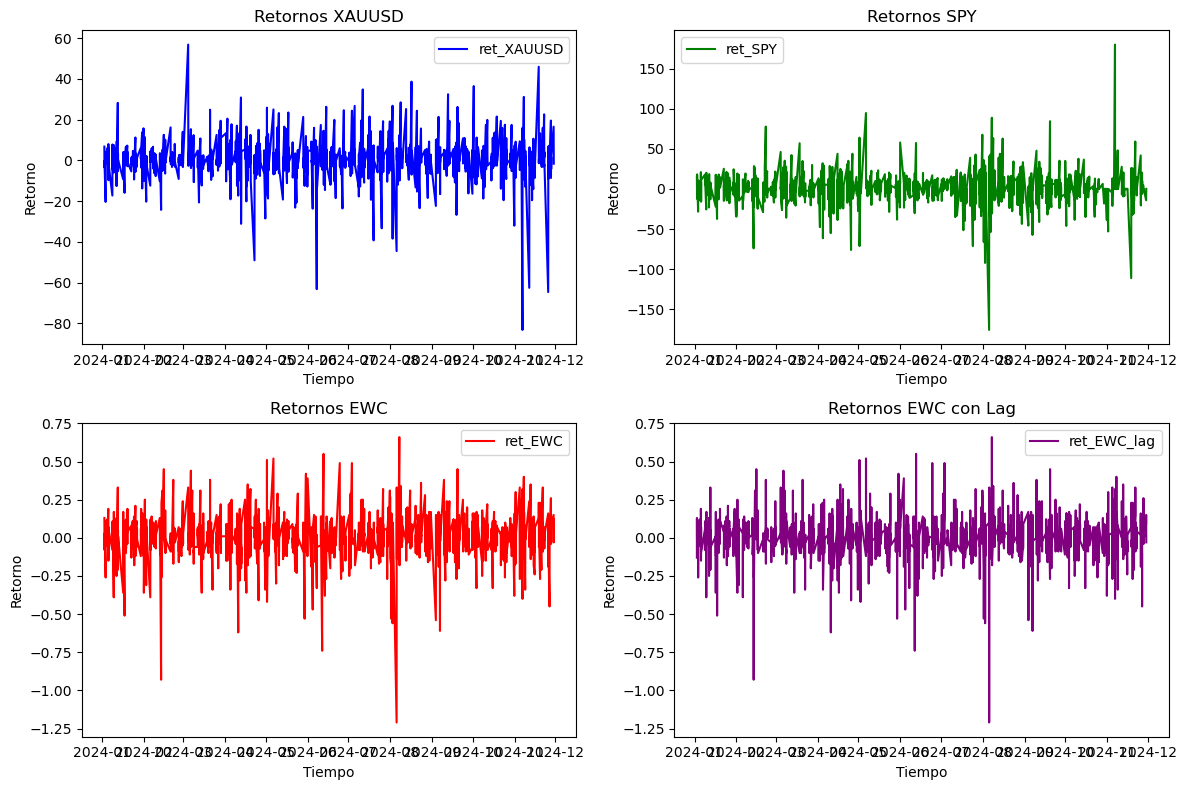

(480, 5)

: 

In [ ]:
# ===========================================
# Download historical data
# ===========================================
from_date = datetime(2024, 1, 1)
to_date = datetime(2024, 12, 1)

def get_data(symbol):
    bars = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_H1, from_date, to_date)
    df = pd.DataFrame(bars)
    print(df.head())
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df

data_XAUUSD = get_data("XAUUSD")
data_SPY = get_data("US500")
data_EWC = get_data("EWC")


# ===========================================
# Lag features
# ===========================================
data_XAUUSD['lag_XAUUSD'] = data_XAUUSD['close'].shift(1)
data_SPY['lag_SPY'] = data_SPY['close'].shift(1)

common_index = data_XAUUSD.index.intersection(data_SPY.index).intersection(data_EWC.index)
print(common_index)

df = pd.DataFrame({
    'ret_XAUUSD': data_XAUUSD.loc[common_index, 'close'] - data_XAUUSD.loc[common_index, 'close'].shift(1),
    'ret_SPY': data_SPY.loc[common_index, 'close'] - data_SPY.loc[common_index, 'close'].shift(1),
    'ret_EWC': data_EWC.loc[common_index, 'close'] - data_EWC.loc[common_index, 'close'].shift(1),
    'ret_EWC_lag': (data_EWC.loc[common_index, 'close'] - data_EWC.loc[common_index, 'close'].shift(1)).shift(1),
    'Price': data_EWC.loc[common_index, 'open']
})

df.dropna(inplace=True)


df.dropna(inplace=True)

plt.figure(figsize=(12, 8))

# Gráfico de los retornos de XAUUSD
plt.subplot(2, 2, 1)
plt.plot(df['ret_XAUUSD'], label='ret_XAUUSD', color='blue')
plt.title('Retornos XAUUSD')
plt.xlabel('Tiempo')
plt.ylabel('Retorno')
plt.legend()

# Gráfico de los retornos de SPY
plt.subplot(2, 2, 2)
plt.plot(df['ret_SPY'], label='ret_SPY', color='green')
plt.title('Retornos SPY')
plt.xlabel('Tiempo')
plt.ylabel('Retorno')
plt.legend()

# Gráfico de los retornos de EWC
plt.subplot(2, 2, 3)
plt.plot(df['ret_EWC'], label='ret_EWC', color='red')
plt.title('Retornos EWC')
plt.xlabel('Tiempo')
plt.ylabel('Retorno')
plt.legend()

# Gráfico de los retornos con retraso de EWC (EWC_lag)
plt.subplot(2, 2, 4)
plt.plot(df['ret_EWC_lag'], label='ret_EWC_lag', color='purple')
plt.title('Retornos EWC con Lag')
plt.xlabel('Tiempo')
plt.ylabel('Retorno')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()

# ===========================================
# Train/test split
# ===========================================
train_size = int(len(df) * 0.7)
train = df[:train_size].copy()
test = df[train_size:].copy()

train.head()
test.head()
test.shape

### Data Handling Considerations

Only the timestamps where all three assets (XAUUSD, SPY, and EWC) overlap have been used to avoid missing values. While this ensures data consistency, it also removes a significant portion of potentially usable information, limiting the number of trades.

Another important consideration is that the strategy relies on **synchronous 1-hour candlesticks**. This means that during the last candle (which is still forming), the strategy cannot be applied reliably.

To address this, it may be useful to:

- Use **lagged returns** to ensure the signals are based on completed data.
- Alternatively, use **tick-level data** to manually compute the return of the last completed hour.

These approaches can help make the strategy more robust and applicable in real-time scenarios.


### Correlation Analysis

In [5]:

# Encuentra el índice con la mayor correlación con 'EWC'
corr_array = train.iloc[:, :-1].corr()['ret_EWC']
print(corr_array)

# Actualizamos la fórmula de regresión para usar los nuevos nombres de columnas 'lag_XLE', 'lag_DBC', 'lag_XAUUSD', 'lag_USDCAD'
formula = 'ret_EWC ~ ret_XAUUSD + ret_SPY'
lm = smf.ols(formula=formula, data=train).fit()

# Muestra el resumen de la regresión
lm.summary()


ret_XAUUSD     0.423517
ret_SPY        0.726625
ret_EWC        1.000000
ret_EWC_lag   -0.030735
Name: ret_EWC, dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ret_EWC   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     838.0
Date:                Wed, 14 May 2025   Prob (F-statistic):          8.11e-223
Time:                        17:37:33   Log-Likelihood:                 1192.6
No. Observations:                1117   AIC:                            -2379.
Df Residuals:                    1114   BIC:                            -2364.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0026      0.002     -1.033      0.302      -0.007       0.002
ret_XAUUSD     0.0046      0.000     14.246      0.000       0.004       0.005
ret_SPY        0.0053      0.000     34.287      0.000       0.005       0.006
==============================================================================
Omnibus:                      220.808   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2150.758
Skew:                          -0.609   Prob(JB):                         0.00
Kurtosis:                       9.688   Cond. No.                         16.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###  Coefficients and P-values

- Coefficients different from zero with **very low p-values** (typically < 0.05) indicate **statistically significant correlations**.
- In this case, both regressors (**ret_XAUUSD** and **ret_SPY**) have **p-values of 0.000**, meaning their influence on **ret_EWC** is statistically significant and unlikely due to chance.

---

###  Omnibus / Jarque-Bera / Skew / Kurtosis

These metrics assess the **normality of residuals**:

- **Omnibus** and **Jarque-Bera**: Composite tests for skewness and kurtosis.
- **Skew**: Indicates asymmetry of residuals. A value far from 0 suggests a non-normal distribution.
- **Kurtosis**: Measures the "tailedness" of residuals. A value far from 3 suggests non-normality.

 Non-normal residuals are **not critical** for practical trading strategies, but they **do matter** if you're applying **parametric statistical tests** (like t-tests or confidence intervals).

---

### Durbin-Watson Statistic

- A value **close to 2** indicates **no autocorrelation in the residuals**, which is ideal.
- If residuals are **autocorrelated**, it means they **contain information not captured by your model** — this violates OLS assumptions and can lead to **misleading inferences or biased trading signals**.

---

### In Summary

- Statistically significant coefficients → ✔️
- Some non-normality in residuals → ⚠️ not ideal but not critical for most trading applications
- No autocorrelation → ✔️ means your model captures the signal fairly well


In [6]:
train['PredictedY'] = lm.predict(train)
test['PredictedY'] = lm.predict(test)

"""
predictions = lm.predict(test)
print("Rango de las predicciones: ", predictions.min(), predictions.max())

print("Primeras predicciones: ", lm.predict(train)[:10])  # Las primeras 10 predicciones en train
print("Primeros valores reales: ", train['EWC'][:10])    # Los primeros 10 valores reales

# Ver si todos los valores en EWC son iguales
is_constant = train['EWC'].nunique() == 1
print("¿Toda la columna EWC tiene un solo valor? ", is_constant)


print("Primeras predicciones: ", lm.predict(test)[:10])  # Las primeras 10 predicciones en train
print("Primeros valores reales: ", test['EWC'][:10])    # Los primeros 10 valores reales

# Ver si todos los valores en EWC son iguales
is_constant = test['EWC'].nunique() == 1
print("¿Toda la columna EWC tiene un solo valor? ", is_constant)
"""


'\npredictions = lm.predict(test)\nprint("Rango de las predicciones: ", predictions.min(), predictions.max())\n\nprint("Primeras predicciones: ", lm.predict(train)[:10])  # Las primeras 10 predicciones en train\nprint("Primeros valores reales: ", train[\'EWC\'][:10])    # Los primeros 10 valores reales\n\n# Ver si todos los valores en EWC son iguales\nis_constant = train[\'EWC\'].nunique() == 1\nprint("¿Toda la columna EWC tiene un solo valor? ", is_constant)\n\n\nprint("Primeras predicciones: ", lm.predict(test)[:10])  # Las primeras 10 predicciones en train\nprint("Primeros valores reales: ", test[\'EWC\'][:10])    # Los primeros 10 valores reales\n\n# Ver si todos los valores en EWC son iguales\nis_constant = test[\'EWC\'].nunique() == 1\nprint("¿Toda la columna EWC tiene un solo valor? ", is_constant)\n'

In [7]:
# RMSE - Root Mean Squared Error, Adjusted R^2
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum()
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()
    SSE = ((data[yname] - data['yhat'])**2).sum()
    r2 = SSR/SST
    adjustR2 = 1 - (1-r2)*(data.shape[0] - 1)/(data.shape[0] -model_k -1)
    RMSE = (SSE/(data.shape[0] -model_k -1))**0.5
    return adjustR2, RMSE

def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment


# Get the assement table fo our model
assessTable(test, train, lm, 3, 'ret_EWC')
#T

,Train,Test
R2,0.599648,0.565237
RMSE,0.083338,0.111533


###  R-squared / Adjusted R-squared

These metrics tell you how much of the variability in the dependent variable (**ret_EWC**) is explained by your regressors (**ret_XAUUSD** and **ret_SPY**):

- **R-squared**: Represents the proportion of the variance in the dependent variable that is predictable from the independent variables.
- **Adjusted R-squared**: Adjusts the R-squared value based on the number of predictors and sample size, helping to prevent overfitting when adding more variables.

### Strategy Implementation

In the strategy, the decision to buy or sell is based on the expected return:

- **If the expected return is positive**, we enter a **long position** (buy).
- **If the expected return is negative**, we enter a **short position** (sell).

This approach assumes that the market will revert to its mean and aims to capitalize on price corrections by taking positions opposite to the current trend.


                     PredictedY  Order
time                                  
2024-01-02 18:00:00    0.110588      1
2024-01-02 19:00:00   -0.047461     -1
2024-01-02 20:00:00   -0.035995     -1
2024-01-02 21:00:00   -0.068591     -1
2024-01-02 22:00:00    0.081662      1
2024-01-03 16:00:00   -0.245491     -1
2024-01-03 17:00:00   -0.058151     -1
2024-01-03 18:00:00   -0.009824     -1
2024-01-03 19:00:00    0.057592      1
2024-01-03 20:00:00   -0.001796     -1
Total profit made in Train:  69.34


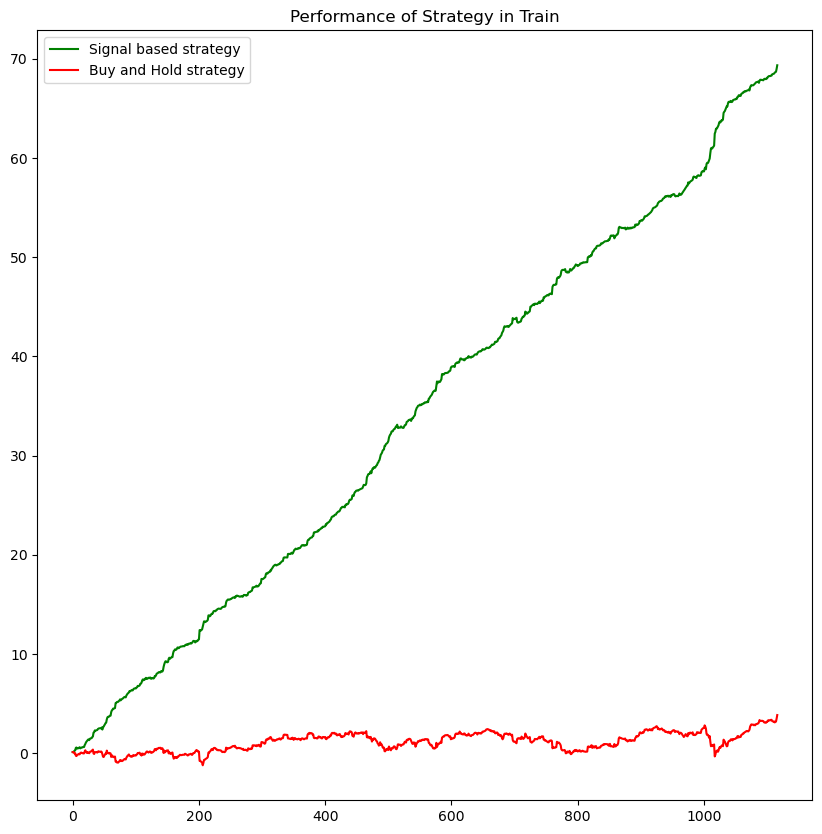

                     PredictedY  Order
time                                  
2024-01-02 18:00:00    0.110588      1
2024-01-02 19:00:00   -0.047461     -1
2024-01-02 20:00:00   -0.035995     -1
2024-01-02 21:00:00   -0.068591     -1
2024-01-02 22:00:00    0.081662      1
2024-01-03 16:00:00   -0.245491     -1
2024-01-03 17:00:00   -0.058151     -1
2024-01-03 18:00:00   -0.009824     -1
2024-01-03 19:00:00    0.057592      1
2024-01-03 20:00:00   -0.001796     -1
Total profit made in Train:  19.739999999999945


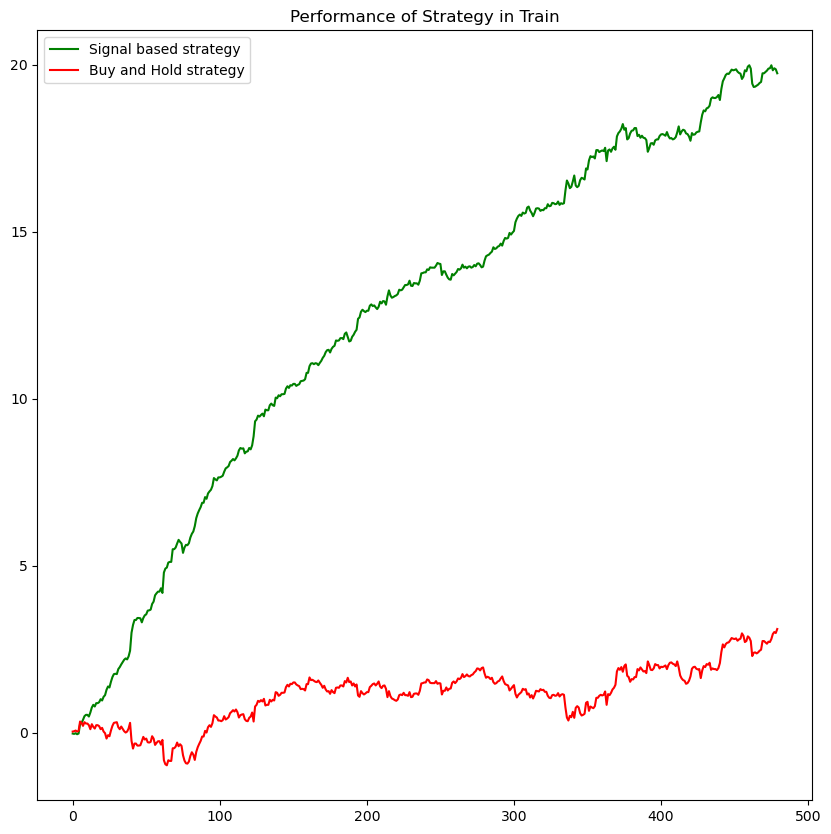

In [8]:
# Train
# Calculamos la señal comparando la predicción con 0
train['Order'] = [1 if pred > 0 else -1 for pred in train['PredictedY']]

print(train[['PredictedY', 'Order']].head(10))

train['Profit'] = train['ret_EWC'] * train['Order']
train['Wealth'] = train['Profit'].cumsum()
print('Total profit made in Train: ', train['Profit'].sum())

plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(train['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(train['ret_EWC'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()


test['Order'] = [1 if pred > 0 else -1 for pred in test['PredictedY']]

print(train[['PredictedY', 'Order']].head(10))

test['Profit'] = test['ret_EWC'] * test['Order']
test['Wealth'] = test['Profit'].cumsum()
print('Total profit made in Train: ', test['Profit'].sum())

plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(test['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(test['ret_EWC'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()




In [25]:
# Ajustar la serie de Wealth sumando el precio inicial (solo si se requiere evitar valores negativos)
train['Wealth'] = train['Wealth'] + train.loc[train.index[0], 'Price']
test['Wealth'] = test['Wealth'] + test.loc[test.index[0], 'Price']

# === Métricas en train ===
# Retornos logarítmicos horarios
train['Return'] = np.log(train['Wealth']) - np.log(train['Wealth'].shift(1))
train_return = train['Return'].dropna()

# Sharpe Ratio horario
hourly_sharpe_train = train_return.mean() / train_return.std(ddof=1)

# Sharpe Ratio diario y anual
daily_sharpe_train = hourly_sharpe_train * np.sqrt(24)
yearly_sharpe_train = hourly_sharpe_train * np.sqrt(252 * 24)

print('Train - Hourly Sharpe Ratio:', hourly_sharpe_train)
print('Train - Daily Sharpe Ratio:', daily_sharpe_train)
print('Train - Yearly Sharpe Ratio:', yearly_sharpe_train)

# Maximum Drawdown
train['Peak'] = train['Wealth'].cummax()
train['Drawdown'] = (train['Peak'] - train['Wealth']) / train['Peak']
print('Train - Maximum Drawdown:', train['Drawdown'].max())


Train - Hourly Sharpe Ratio: 0.5270669265658294
Train - Daily Sharpe Ratio: 2.5820900607665074
Train - Yearly Sharpe Ratio: 40.98940898135901
Train - Maximum Drawdown: 0.006233636703652731


In [26]:

# === Métricas en test ===
test['Return'] = np.log(test['Wealth']) - np.log(test['Wealth'].shift(1))
test_return = test['Return'].dropna()

# Sharpe Ratio horario
hourly_sharpe_test = test_return.mean() / test_return.std(ddof=1)

# Sharpe Ratio diario y anual
daily_sharpe_test = hourly_sharpe_test * np.sqrt(24)
yearly_sharpe_test = hourly_sharpe_test * np.sqrt(252 * 24)

print('Test - Hourly Sharpe Ratio:', hourly_sharpe_test)
print('Test - Daily Sharpe Ratio:', daily_sharpe_test)
print('Test - Yearly Sharpe Ratio:', yearly_sharpe_test)

# Maximum Drawdown
test['Peak'] = test['Wealth'].cummax()
test['Drawdown'] = (test['Peak'] - test['Wealth']) / test['Peak']
print('Test - Maximum Drawdown:', test['Drawdown'].max())





Test - Hourly Sharpe Ratio: 0.3865536084201449
Test - Daily Sharpe Ratio: 1.89371819772194
Test - Yearly Sharpe Ratio: 30.061844426458183
Test - Maximum Drawdown: 0.014219633373308423
